🚀 Iniciando Análise Avançada de Vendas
📤 Faça upload dos arquivos CSV (clientes, produtos, vendas, itens_venda).


Saving clientes.csv to clientes (2).csv
Saving itens_venda.csv to itens_venda (2).csv
Saving produtos.csv to produtos (2).csv
Saving vendas.csv to vendas (2).csv

Resumo:
Total de Vendas: R$ 30,097.80
Lucro Total: R$ 10,168.00
Clientes únicos: 19


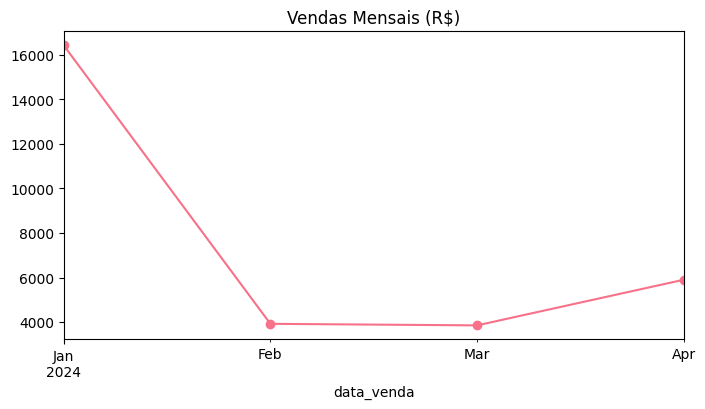

In [ ]:
# advanced_sales_analysis_normalized.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
import io
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")


class AdvancedSalesAnalyzer:
    def __init__(self):
        self.clientes = None
        self.produtos = None
        self.vendas = None
        self.itens_venda = None
        self.load_data()

    # ============================
    #   CARGA DE DADOS
    # ============================
    def load_data(self):
        print("📤 Faça upload dos arquivos CSV (clientes, produtos, vendas, itens_venda).")
        try:
            uploaded = files.upload()
        except:
            uploaded = {}

        if not uploaded:
            print("⚠️ Nenhum arquivo enviado. Gerando dados de exemplo.")
            self._create_all_samples()
            return

        for fname, content in uploaded.items():
            df = pd.read_csv(io.BytesIO(content))

            # Normaliza: minúsculas + troca espaços/acentos por "_"
            df.columns = (
                df.columns.str.strip()
                .str.lower()
                .str.normalize("NFKD")
                .str.encode("ascii", errors="ignore")
                .str.decode("utf-8")
                .str.replace(r"[^0-9a-z_]", "_", regex=True)
            )

            cols = set(df.columns)

            if "cliente_id" in cols and {"nome", "email"}.issubset(cols):
                self.clientes = df
            elif "produto_id" in cols and "preco" in cols:
                self.produtos = df
            elif "venda_id" in cols and "cliente_id" in cols:
                self.vendas = df
            elif "venda_id" in cols and "produto_id" in cols:
                self.itens_venda = df

        # Caso algo falte, cria exemplos
        if any(x is None for x in [self.clientes, self.produtos, self.vendas, self.itens_venda]):
            print("⚠️ Algum arquivo essencial está faltando. Gerando dados de exemplo.")
            self._create_all_samples()

        # Converte datas se existirem
        for df, col in [(self.vendas, "data_venda"), (self.clientes, "data_cadastro")]:
            if df is not None and col in df.columns:
                df[col] = pd.to_datetime(df[col], errors="coerce")

    # ============================
    #   DADOS DE EXEMPLO
    # ============================
    def _create_all_samples(self):
        self._create_sample_clientes()
        self._create_sample_produtos()
        self._create_sample_vendas()

    def _create_sample_clientes(self):
        self.clientes = pd.DataFrame({
            'cliente_id': range(1, 101),
            'nome': [f'Cliente {i}' for i in range(1, 101)],
            'email': [f'cliente{i}@email.com' for i in range(1, 101)],
            'cidade': np.random.choice(['SP', 'RJ', 'BH', 'POA'], 100),
            'estado': np.random.choice(['SP', 'RJ', 'MG', 'RS'], 100),
            'data_cadastro': pd.date_range('2023-01-01', periods=100, freq='D')
        })

    def _create_sample_produtos(self):
        categorias = ['Eletronicos', 'Roupas', 'Casa', 'Esportes']
        self.produtos = pd.DataFrame({
            'produto_id': range(1, 51),
            'nome': [f'Produto {i}' for i in range(1, 51)],
            'categoria': np.random.choice(categorias, 50),
            'preco': np.round(np.random.uniform(20, 500, 50), 2),
            'custo': np.round(np.random.uniform(10, 300, 50), 2)
        })

    def _create_sample_vendas(self):
        vendas, itens = [], []
        for vid in range(1, 301):
            cid = np.random.randint(1, 101)
            data = pd.Timestamp('2024-01-01') + pd.to_timedelta(np.random.randint(0, 180), 'D')
            total = 0
            for _ in range(np.random.randint(1, 4)):
                pid = np.random.randint(1, 51)
                qtd = np.random.randint(1, 4)
                preco = self.produtos.loc[self.produtos['produto_id'] == pid, 'preco'].values[0]
                total += preco * qtd
                itens.append({
                    'item_id': len(itens)+1,
                    'venda_id': vid,
                    'produto_id': pid,
                    'quantidade': qtd,
                    'preco_unitario': preco,
                    'total_item': preco * qtd
                })
            vendas.append({'venda_id': vid, 'cliente_id': cid,
                           'data_venda': data, 'total_venda': total})
        self.vendas = pd.DataFrame(vendas)
        self.itens_venda = pd.DataFrame(itens)

    # ============================
    #   COMBINAÇÃO SEGURA
    # ============================
    def get_combined_data(self):
        needed = [self.vendas, self.clientes, self.itens_venda, self.produtos]
        if any(df is None for df in needed):
            print("❌ Dados ausentes para combinar.")
            return pd.DataFrame()

        df = self.vendas.merge(self.clientes, on='cliente_id', how='left')
        df = df.merge(self.itens_venda.merge(self.produtos, on='produto_id'),
                      on='venda_id', how='left')
        if 'custo' in df.columns:
            df['lucro'] = (df['preco_unitario'] - df['custo']) * df['quantidade']
            df['margem'] = (df['lucro'] / df['total_item']) * 100
        return df

    # ============================
    #   RELATÓRIO RESUMIDO
    # ============================
    def generate_report(self):
        df = self.get_combined_data()
        if df.empty:
            return
        print("\nResumo:")
        print(f"Total de Vendas: R$ {df['total_venda'].sum():,.2f}")
        if 'lucro' in df.columns:
            print(f"Lucro Total: R$ {df['lucro'].sum():,.2f}")
        print(f"Clientes únicos: {df['cliente_id'].nunique()}")

        vendas_mensais = df.groupby(df['data_venda'].dt.to_period('M'))['total_venda'].sum()
        vendas_mensais.plot(marker='o', figsize=(8,4), title='Vendas Mensais (R$)')
        plt.show()


# ============================
#   EXECUÇÃO
# ============================
if __name__ == "__main__":
    print("🚀 Iniciando Análise Avançada de Vendas")
    analyzer = AdvancedSalesAnalyzer()
    analyzer.generate_report()




Análise de Cohort (retenção de clientes)

Objetivo: entender em que mês de cadastro os clientes entraram e como continuam comprando.

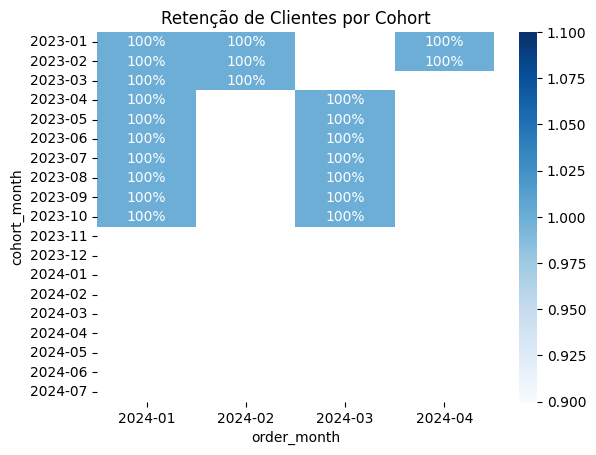

In [ ]:
df = analyzer.get_combined_data()

df['cohort_month'] = df['data_cadastro'].dt.to_period('M')
df['order_month'] = df['data_venda'].dt.to_period('M')

cohort = (
    df.groupby(['cohort_month','order_month'])['cliente_id']
      .nunique()
      .unstack()
)

# Normaliza para % de retenção
cohort_retention = cohort.divide(cohort.iloc[:,0], axis=0)
sns.heatmap(cohort_retention, cmap="Blues", annot=True, fmt=".0%")
plt.title("Retenção de Clientes por Cohort")
plt.show()


ANÁLISE DE VENDAS - RELATÓRIO COMPLETO

1. VISÃO GERAL DOS DADOS
----------------------------------------
Total de vendas: 40
Total de clientes: 20
Total de produtos: 20
Período das vendas: 2024-01-05 a 2024-04-12
Valor total vendido: R$ 28,498.00

2. ANÁLISE TEMPORAL
----------------------------------------
Vendas por mês:
            Total_Vendas  Ticket_Médio  Qtd_Vendas
data_venda                                        
2024-01        14,829.40      1,482.94          10
2024-02         3,919.50        326.62          12
2024-03         3,849.40        320.78          12
2024-04         5,899.70        983.28           6

3. ANÁLISE DE CLIENTES
----------------------------------------
Vendas por estado:
        Qtd_Clientes  Total_Vendas  Ticket_Médio
estado                                          
SP                 1      5,199.90      1,733.30
RS                 1      4,799.90      2,399.95
ES                 1      3,750.00      1,875.00
DF                 1      2,599.90     

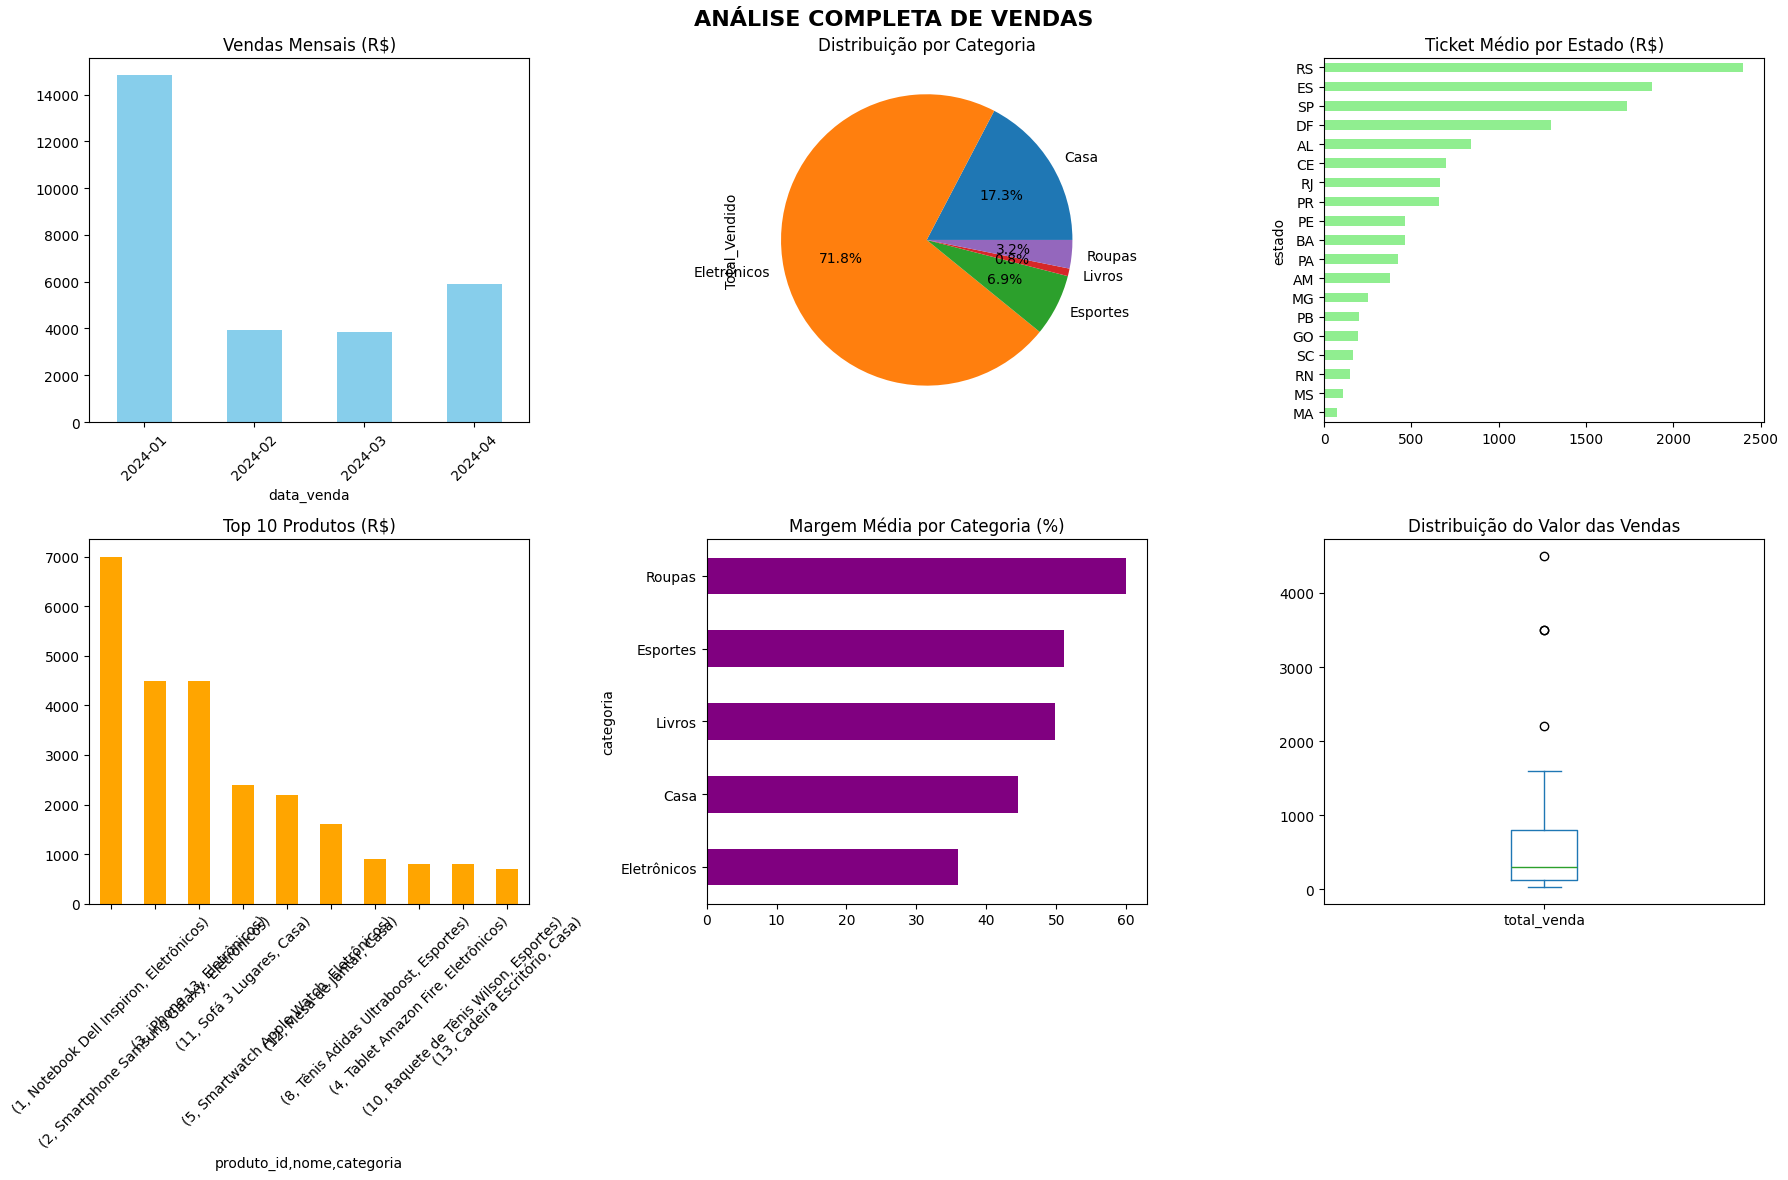


9. ANÁLISE DE TENDÊNCIAS
----------------------------------------
Crescimento mensal (%):
2024-02: -73.6%
2024-03: -1.8%
2024-04: +53.3%

10. RELATÓRIO DE PERFORMANCE
----------------------------------------
📈 Faturamento Total: R$ 28,498.00
👥 Clientes Ativos: 19
🛒 Ticket Médio: R$ 712.45
🏆 Categoria Top: Casa (R$ 4,940.00)
⭐ Produto Top: Notebook Dell Inspiron (R$ 7,000.00)
📊 Margem Média: 45.8%

11. EXPORTANDO RELATÓRIO...
----------------------------------------


/tmp/ipython-input-1146682219.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vendas_mensais = vendas_df.set_index('data_venda').resample('M')['total_venda'].sum()


✅ Relatório exportado como 'relatorio_vendas.xlsx'
✅ Análise concluída com sucesso!

ESTATÍSTICAS FINAIS
Total de transações analisadas: 40
Valor total movimentado: R$ 28,498.00
Número de produtos diferentes: 20
Clientes únicos: 19
Período analisado: 98 dias


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuração de estilo
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.float_format', '{:,.2f}'.format)

# Carregar os dados
vendas_df = pd.read_csv('vendas.csv')
clientes_df = pd.read_csv('clientes.csv')
itens_venda_df = pd.read_csv('itens_venda.csv')
produtos_df = pd.read_csv('produtos.csv')

# Converter datas para o formato datetime
vendas_df['data_venda'] = pd.to_datetime(vendas_df['data_venda'])
clientes_df['data_cadastro'] = pd.to_datetime(clientes_df['data_cadastro'])

# 1. ANÁLISE EXPLORATÓRIA INICIAL
print("=" * 60)
print("ANÁLISE DE VENDAS - RELATÓRIO COMPLETO")
print("=" * 60)

print("\n1. VISÃO GERAL DOS DADOS")
print("-" * 40)
print(f"Total de vendas: {len(vendas_df):,}")
print(f"Total de clientes: {len(clientes_df):,}")
print(f"Total de produtos: {len(produtos_df):,}")
print(f"Período das vendas: {vendas_df['data_venda'].min().date()} a {vendas_df['data_venda'].max().date()}")
print(f"Valor total vendido: R$ {vendas_df['total_venda'].sum():,.2f}")

# 2. ANÁLISE TEMPORAL DAS VENDAS
print("\n2. ANÁLISE TEMPORAL")
print("-" * 40)

# Vendas por mês
vendas_por_mes = vendas_df.groupby(vendas_df['data_venda'].dt.to_period('M')).agg({
    'total_venda': ['sum', 'mean', 'count']
}).round(2)
vendas_por_mes.columns = ['Total_Vendas', 'Ticket_Médio', 'Qtd_Vendas']
print("Vendas por mês:")
print(vendas_por_mes)

# 3. ANÁLISE DE CLIENTES
print("\n3. ANÁLISE DE CLIENTES")
print("-" * 40)

# Juntar dados de clientes com vendas
vendas_clientes = pd.merge(vendas_df, clientes_df, on='cliente_id')

# Clientes por estado
clientes_estado = vendas_clientes.groupby('estado').agg({
    'cliente_id': 'nunique',
    'total_venda': ['sum', 'mean']
}).round(2)
clientes_estado.columns = ['Qtd_Clientes', 'Total_Vendas', 'Ticket_Médio']
print("Vendas por estado:")
print(clientes_estado.sort_values('Total_Vendas', ascending=False))

# Top 10 clientes por valor gasto
top_clientes = vendas_clientes.groupby(['cliente_id', 'nome']).agg({
    'total_venda': ['sum', 'count'],
    'data_venda': 'max'
}).round(2)
top_clientes.columns = ['Total_Gasto', 'Qtd_Compras', 'Última_Compra']
print("\nTop 10 clientes por valor gasto:")
print(top_clientes.sort_values('Total_Gasto', ascending=False).head(10))

# 4. ANÁLISE DE PRODUTOS
print("\n4. ANÁLISE DE PRODUTOS")
print("-" * 40)

# Juntar dados de produtos com itens de venda
produtos_vendas = pd.merge(itens_venda_df, produtos_df, on='produto_id')

# Produtos mais vendidos
produtos_mais_vendidos = produtos_vendas.groupby(['produto_id', 'nome', 'categoria']).agg({
    'quantidade': 'sum',
    'total_item': 'sum',
    'preco_unitario': 'mean'
}).round(2)
produtos_mais_vendidos.columns = ['Qtd_Vendida', 'Total_Vendido', 'Preço_Médio']
print("Top 10 produtos mais vendidos:")
print(produtos_mais_vendidos.sort_values('Total_Vendido', ascending=False).head(10))

# Vendas por categoria
vendas_categoria = produtos_vendas.groupby('categoria').agg({
    'quantidade': 'sum',
    'total_item': 'sum',
    'produto_id': 'nunique'
}).round(2)
vendas_categoria.columns = ['Qtd_Vendida', 'Total_Vendido', 'Qtd_Produtos']
print("\nVendas por categoria:")
print(vendas_categoria.sort_values('Total_Vendido', ascending=False))

# 5. ANÁLISE DE LUCRO
print("\n5. ANÁLISE DE LUCRO E MARGEM")
print("-" * 40)

# Calcular lucro por produto
produtos_vendas['lucro'] = produtos_vendas['preco_unitario'] - produtos_vendas['custo']
produtos_vendas['margem'] = (produtos_vendas['lucro'] / produtos_vendas['preco_unitario']) * 100

# Lucro por categoria
lucro_categoria = produtos_vendas.groupby('categoria').agg({
    'lucro': 'sum',
    'margem': 'mean'
}).round(2)
lucro_categoria.columns = ['Lucro_Total', 'Margem_Média(%)']
print("Lucro por categoria:")
print(lucro_categoria.sort_values('Lucro_Total', ascending=False))

# 6. ANÁLISE DE TICKET MÉDIO
print("\n6. ANÁLISE DE TICKET MÉDIO")
print("-" * 40)

ticket_medio_geral = vendas_df['total_venda'].mean()
ticket_medio_estado = vendas_clientes.groupby('estado')['total_venda'].mean().round(2)
ticket_medio_categoria = produtos_vendas.groupby('categoria')['preco_unitario'].mean().round(2)

print(f"Ticket médio geral: R$ {ticket_medio_geral:.2f}")
print("\nTicket médio por estado:")
print(ticket_medio_estado.sort_values(ascending=False))
print("\nTicket médio por categoria:")
print(ticket_medio_categoria.sort_values(ascending=False))

# 7. ANÁLISE DE RECORRÊNCIA DE CLIENTES
print("\n7. ANÁLISE DE RECORRÊNCIA")
print("-" * 40)

clientes_recorrentes = vendas_df['cliente_id'].value_counts()
clientes_uma_compra = (clientes_recorrentes == 1).sum()
clientes_multiplas = (clientes_recorrentes > 1).sum()

print(f"Clientes com apenas 1 compra: {clientes_uma_compra}")
print(f"Clientes com múltiplas compras: {clientes_multiplas}")
print(f"Taxa de retenção: {(clientes_multiplas/len(clientes_recorrentes)*100):.1f}%")

# 8. VISUALIZAÇÕES GRÁFICAS
print("\n8. GERANDO VISUALIZAÇÕES...")
print("-" * 40)

# Configurar o estilo dos gráficos
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('ANÁLISE COMPLETA DE VENDAS', fontsize=16, fontweight='bold')

# Gráfico 1: Vendas por mês
vendas_mes = vendas_df.groupby(vendas_df['data_venda'].dt.to_period('M'))['total_venda'].sum()
vendas_mes.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Vendas Mensais (R$)')
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2: Vendas por categoria
vendas_categoria['Total_Vendido'].plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Distribuição por Categoria')

# Gráfico 3: Ticket médio por estado
ticket_medio_estado.sort_values(ascending=True).plot(kind='barh', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Ticket Médio por Estado (R$)')

# Gráfico 4: Top 10 produtos
produtos_mais_vendidos['Total_Vendido'].sort_values(ascending=False).head(10).plot(
    kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Top 10 Produtos (R$)')
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 5: Margem por categoria
lucro_categoria['Margem_Média(%)'].sort_values(ascending=True).plot(
    kind='barh', ax=axes[1,1], color='purple')
axes[1,1].set_title('Margem Média por Categoria (%)')

# Gráfico 6: Distribuição de vendas
vendas_df['total_venda'].plot(kind='box', ax=axes[1,2])
axes[1,2].set_title('Distribuição do Valor das Vendas')

plt.tight_layout()
plt.show()

# 9. ANÁLISE AVANÇADA: SÉRIE TEMPORAL E TENDÊNCIAS
print("\n9. ANÁLISE DE TENDÊNCIAS")
print("-" * 40)

# Calcular crescimento mensal
vendas_mensais = vendas_df.set_index('data_venda').resample('M')['total_venda'].sum()
crescimento_mensal = vendas_mensais.pct_change() * 100

print("Crescimento mensal (%):")
for i in range(1, len(crescimento_mensal)):
    mes = crescimento_mensal.index[i].strftime('%Y-%m')
    crescimento = crescimento_mensal.iloc[i]
    print(f"{mes}: {crescimento:+.1f}%")

# 10. RELATÓRIO DE PERFORMANCE
print("\n10. RELATÓRIO DE PERFORMANCE")
print("-" * 40)

print(f"📈 Faturamento Total: R$ {vendas_df['total_venda'].sum():,.2f}")
print(f"👥 Clientes Ativos: {vendas_df['cliente_id'].nunique()}")
print(f"🛒 Ticket Médio: R$ {vendas_df['total_venda'].mean():.2f}")
print(f"🏆 Categoria Top: {vendas_categoria.index[0]} (R$ {vendas_categoria['Total_Vendido'].iloc[0]:,.2f})")
print(f"⭐ Produto Top: {produtos_mais_vendidos.index[0][1]} (R$ {produtos_mais_vendidos['Total_Vendido'].iloc[0]:,.2f})")
print(f"📊 Margem Média: {produtos_vendas['margem'].mean():.1f}%")

# 11. EXPORTAR RELATÓRIO
print("\n11. EXPORTANDO RELATÓRIO...")
print("-" * 40)

# Criar um arquivo Excel com as análises
with pd.ExcelWriter('relatorio_vendas.xlsx') as writer:
    vendas_por_mes.to_excel(writer, sheet_name='Vendas_Mensais')
    clientes_estado.to_excel(writer, sheet_name='Vendas_Estado')
    produtos_mais_vendidos.to_excel(writer, sheet_name='Produtos')
    vendas_categoria.to_excel(writer, sheet_name='Categorias')
    lucro_categoria.to_excel(writer, sheet_name='Lucro')

print("✅ Relatório exportado como 'relatorio_vendas.xlsx'")
print("✅ Análise concluída com sucesso!")

# Mostrar estatísticas finais
print("\n" + "=" * 60)
print("ESTATÍSTICAS FINAIS")
print("=" * 60)
print(f"Total de transações analisadas: {len(vendas_df):,}")
print(f"Valor total movimentado: R$ {vendas_df['total_venda'].sum():,.2f}")
print(f"Número de produtos diferentes: {len(produtos_df):,}")
print(f"Clientes únicos: {vendas_df['cliente_id'].nunique():,}")
print(f"Período analisado: {(vendas_df['data_venda'].max() - vendas_df['data_venda'].min()).days} dias")

ANÁLISE DE VENDAS - RELATÓRIO COMPLETO

1. VISÃO GERAL DOS DADOS
----------------------------------------
Total de vendas: 40
Total de clientes: 20
Total de produtos: 20
Período das vendas: 2024-01-05 a 2024-04-12
Valor total vendido: R$ 28,498.00

2. ANÁLISE TEMPORAL
----------------------------------------
            Total_Vendas  Ticket_Médio  Qtd_Vendas
data_venda                                        
2024-01        14,829.40      1,482.94          10
2024-02         3,919.50        326.62          12
2024-03         3,849.40        320.78          12
2024-04         5,899.70        983.28           6

3. ANÁLISE DE CLIENTES
----------------------------------------
        Qtd_Clientes  Total_Vendas  Ticket_Médio
estado                                          
SP                 1      5,199.90      1,733.30
RS                 1      4,799.90      2,399.95
ES                 1      3,750.00      1,875.00
DF                 1      2,599.90      1,299.95
RJ                 1     

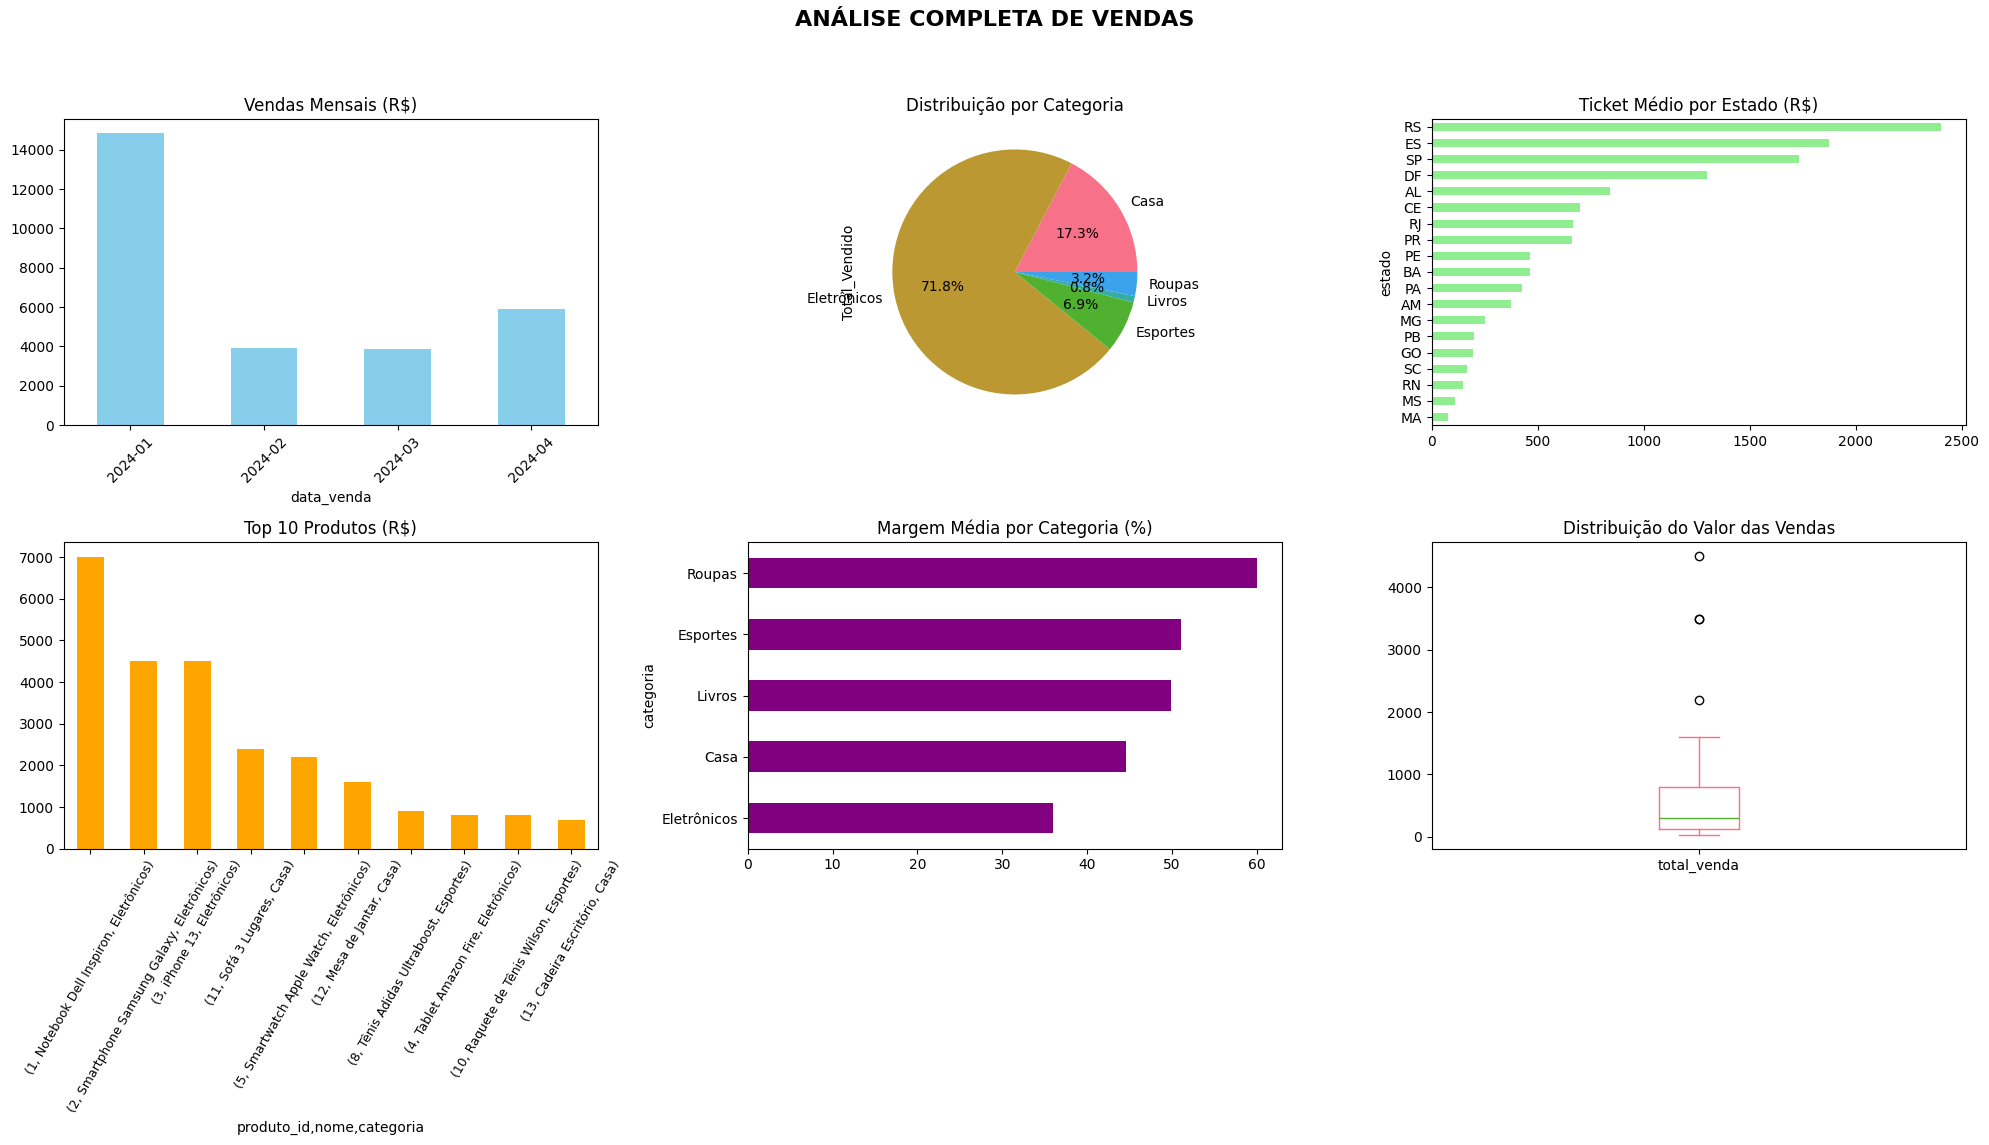


9. ANÁLISE DE TENDÊNCIAS
----------------------------------------
2024-02: -73.6%
2024-03: -1.8%
2024-04: +53.3%

10. RELATÓRIO DE PERFORMANCE
----------------------------------------
📈 Faturamento Total: R$ 28,498.00
👥 Clientes Ativos: 19
🛒 Ticket Médio: R$ 712.45
🏆 Categoria Top: Casa (R$ 4,940.00)
⭐ Produto Top: Notebook Dell Inspiron (R$ 7,000.00)
📊 Margem Média: 45.8%

11. EXPORTANDO RELATÓRIO...
----------------------------------------


/tmp/ipython-input-2841180819.py:165: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vendas_mensais = vendas_df.set_index('data_venda').resample('M')['total_venda'].sum()


✅ Relatório exportado como 'relatorio_vendas.xlsx'
✅ Análise concluída com sucesso!

ESTATÍSTICAS FINAIS
Total de transações analisadas: 40
Valor total movimentado: R$ 28,498.00
Número de produtos diferentes: 20
Clientes únicos: 19
Período analisado: 98 dias


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ===================== CONFIGURAÇÕES =====================
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.float_format', '{:,.2f}'.format)

# ===================== CARREGAR DADOS ====================
vendas_df   = pd.read_csv('vendas.csv')
clientes_df = pd.read_csv('clientes.csv')
itens_venda_df = pd.read_csv('itens_venda.csv')
produtos_df = pd.read_csv('produtos.csv')

# Converter datas
vendas_df['data_venda']   = pd.to_datetime(vendas_df['data_venda'])
clientes_df['data_cadastro'] = pd.to_datetime(clientes_df['data_cadastro'])

# ===================== 1. VISÃO GERAL =====================
print("="*60)
print("ANÁLISE DE VENDAS - RELATÓRIO COMPLETO")
print("="*60)

print("\n1. VISÃO GERAL DOS DADOS")
print("-"*40)
print(f"Total de vendas: {len(vendas_df):,}")
print(f"Total de clientes: {len(clientes_df):,}")
print(f"Total de produtos: {len(produtos_df):,}")
print(f"Período das vendas: {vendas_df['data_venda'].min().date()} a {vendas_df['data_venda'].max().date()}")
print(f"Valor total vendido: R$ {vendas_df['total_venda'].sum():,.2f}")

# ===================== 2. ANÁLISE TEMPORAL ================
print("\n2. ANÁLISE TEMPORAL")
print("-"*40)
vendas_por_mes = vendas_df.groupby(vendas_df['data_venda'].dt.to_period('M')).agg({
    'total_venda': ['sum','mean','count']
}).round(2)
vendas_por_mes.columns = ['Total_Vendas','Ticket_Médio','Qtd_Vendas']
print(vendas_por_mes)

# ===================== 3. CLIENTES ========================
print("\n3. ANÁLISE DE CLIENTES")
print("-"*40)
vendas_clientes = pd.merge(vendas_df, clientes_df, on='cliente_id')

clientes_estado = vendas_clientes.groupby('estado').agg({
    'cliente_id': 'nunique',
    'total_venda': ['sum','mean']
}).round(2)
clientes_estado.columns = ['Qtd_Clientes','Total_Vendas','Ticket_Médio']
print(clientes_estado.sort_values('Total_Vendas', ascending=False))

top_clientes = vendas_clientes.groupby(['cliente_id','nome']).agg({
    'total_venda': ['sum','count'],
    'data_venda': 'max'
}).round(2)
top_clientes.columns = ['Total_Gasto','Qtd_Compras','Última_Compra']
print("\nTop 10 clientes por valor gasto:")
print(top_clientes.sort_values('Total_Gasto', ascending=False).head(10))

# ===================== 4. PRODUTOS ========================
print("\n4. ANÁLISE DE PRODUTOS")
print("-"*40)
produtos_vendas = pd.merge(itens_venda_df, produtos_df, on='produto_id')

produtos_mais_vendidos = produtos_vendas.groupby(
    ['produto_id','nome','categoria']).agg({
        'quantidade':'sum',
        'total_item':'sum',
        'preco_unitario':'mean'
}).round(2)
produtos_mais_vendidos.columns = ['Qtd_Vendida','Total_Vendido','Preço_Médio']
print("Top 10 produtos mais vendidos:")
print(produtos_mais_vendidos.sort_values('Total_Vendido', ascending=False).head(10))

vendas_categoria = produtos_vendas.groupby('categoria').agg({
    'quantidade':'sum',
    'total_item':'sum',
    'produto_id':'nunique'
}).round(2)
vendas_categoria.columns = ['Qtd_Vendida','Total_Vendido','Qtd_Produtos']
print("\nVendas por categoria:")
print(vendas_categoria.sort_values('Total_Vendido', ascending=False))

# ===================== 5. LUCRO ==========================
print("\n5. ANÁLISE DE LUCRO E MARGEM")
print("-"*40)
produtos_vendas['lucro']  = produtos_vendas['preco_unitario'] - produtos_vendas['custo']
produtos_vendas['margem'] = (produtos_vendas['lucro'] / produtos_vendas['preco_unitario']) * 100

lucro_categoria = produtos_vendas.groupby('categoria').agg({
    'lucro':'sum',
    'margem':'mean'
}).round(2)
lucro_categoria.columns = ['Lucro_Total','Margem_Média(%)']
print(lucro_categoria.sort_values('Lucro_Total', ascending=False))

# ===================== 6. TICKET MÉDIO ===================
print("\n6. ANÁLISE DE TICKET MÉDIO")
print("-"*40)
ticket_medio_geral    = vendas_df['total_venda'].mean()
ticket_medio_estado   = vendas_clientes.groupby('estado')['total_venda'].mean().round(2)
ticket_medio_categoria= produtos_vendas.groupby('categoria')['preco_unitario'].mean().round(2)
print(f"Ticket médio geral: R$ {ticket_medio_geral:.2f}")
print(ticket_medio_estado.sort_values(ascending=False))
print(ticket_medio_categoria.sort_values(ascending=False))

# ===================== 7. RECORRÊNCIA ====================
print("\n7. ANÁLISE DE RECORRÊNCIA")
print("-"*40)
clientes_recorrentes = vendas_df['cliente_id'].value_counts()
clientes_uma_compra  = (clientes_recorrentes==1).sum()
clientes_multiplas   = (clientes_recorrentes>1).sum()
print(f"Clientes com apenas 1 compra: {clientes_uma_compra}")
print(f"Clientes com múltiplas compras: {clientes_multiplas}")
print(f"Taxa de retenção: {(clientes_multiplas/len(clientes_recorrentes)*100):.1f}%")

# ===================== 8. VISUALIZAÇÕES ==================
print("\n8. GERANDO VISUALIZAÇÕES...")
print("-"*40)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # tamanho maior
fig.suptitle('ANÁLISE COMPLETA DE VENDAS', fontsize=16, fontweight='bold')

# Gráfico 1
vendas_mes = vendas_df.groupby(vendas_df['data_venda'].dt.to_period('M'))['total_venda'].sum()
vendas_mes.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Vendas Mensais (R$)')
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2
vendas_categoria['Total_Vendido'].plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Distribuição por Categoria')

# Gráfico 3
ticket_medio_estado.sort_values(ascending=True).plot(kind='barh', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Ticket Médio por Estado (R$)')

# Gráfico 4 – **CORRIGIDO**
produtos_mais_vendidos['Total_Vendido'].sort_values(ascending=False).head(10).plot(
    kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Top 10 Produtos (R$)')
axes[1,0].tick_params(axis='x', rotation=60, labelsize=9)  # 🔑 rotação maior + fonte menor

# Gráfico 5
lucro_categoria['Margem_Média(%)'].sort_values(ascending=True).plot(
    kind='barh', ax=axes[1,1], color='purple')
axes[1,1].set_title('Margem Média por Categoria (%)')

# Gráfico 6
vendas_df['total_venda'].plot(kind='box', ax=axes[1,2])
axes[1,2].set_title('Distribuição do Valor das Vendas')

plt.tight_layout(rect=[0,0.03,1,0.95])  # garante espaçamento
plt.show()

# ===================== 9. TENDÊNCIAS =====================
print("\n9. ANÁLISE DE TENDÊNCIAS")
print("-"*40)
vendas_mensais = vendas_df.set_index('data_venda').resample('M')['total_venda'].sum()
crescimento_mensal = vendas_mensais.pct_change() * 100
for i in range(1,len(crescimento_mensal)):
    mes = crescimento_mensal.index[i].strftime('%Y-%m')
    print(f"{mes}: {crescimento_mensal.iloc[i]:+.1f}%")

# ===================== 10. PERFORMANCE ===================
print("\n10. RELATÓRIO DE PERFORMANCE")
print("-"*40)
print(f"📈 Faturamento Total: R$ {vendas_df['total_venda'].sum():,.2f}")
print(f"👥 Clientes Ativos: {vendas_df['cliente_id'].nunique()}")
print(f"🛒 Ticket Médio: R$ {vendas_df['total_venda'].mean():.2f}")
print(f"🏆 Categoria Top: {vendas_categoria.index[0]} (R$ {vendas_categoria['Total_Vendido'].iloc[0]:,.2f})")
print(f"⭐ Produto Top: {produtos_mais_vendidos.index[0][1]} (R$ {produtos_mais_vendidos['Total_Vendido'].iloc[0]:,.2f})")
print(f"📊 Margem Média: {produtos_vendas['margem'].mean():.1f}%")

# ===================== 11. EXPORTAR ======================
print("\n11. EXPORTANDO RELATÓRIO...")
print("-"*40)
with pd.ExcelWriter('relatorio_vendas.xlsx') as writer:
    vendas_por_mes.to_excel(writer, sheet_name='Vendas_Mensais')
    clientes_estado.to_excel(writer, sheet_name='Vendas_Estado')
    produtos_mais_vendidos.to_excel(writer, sheet_name='Produtos')
    vendas_categoria.to_excel(writer, sheet_name='Categorias')
    lucro_categoria.to_excel(writer, sheet_name='Lucro')
print("✅ Relatório exportado como 'relatorio_vendas.xlsx'")
print("✅ Análise concluída com sucesso!")

print("\n" + "="*60)
print("ESTATÍSTICAS FINAIS")
print("="*60)
print(f"Total de transações analisadas: {len(vendas_df):,}")
print(f"Valor total movimentado: R$ {vendas_df['total_venda'].sum():,.2f}")
print(f"Número de produtos diferentes: {len(produtos_df):,}")
print(f"Clientes únicos: {vendas_df['cliente_id'].nunique():,}")
print(f"Período analisado: {(vendas_df['data_venda'].max() - vendas_df['data_venda'].min()).days} dias")
